### **Title : Using Age and Maximum Heart Rate to Determine a Patient's Risk of Heart Disease**

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(rvest)
library(stringr)
options(repr.matrix.max.rows = 6)
set.seed(10)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.4     ✔ yardstick    1.1.0
✔ recipes      1.0.3     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ 

#### **Introduction**
Heart diseases are often associated with chest discomfort and difficulty breathing. However, other symptoms also include fatigue, lightheadedness, slowed heartbeat (bradycardia), and weakness or coldness in the legs or arms (mayoclinic.org). All of these symptoms can be attributed to a weaknening of the heart muscles, which then causes a lack of oxygenated blood reaching the body, such as the limbs and the brain. Cardiomyopathy is a type of heart condition that is asscociated with inhibited heart muscle activity due to enlargement or rigid formation of heart muscles (heart.org). Information obtained from www.heart.org and www.mayoclinic.org

**Question: Is low maximum heart rate and weakened heart muscle an indication of possible disease?**

We chose the Cleveland heart disease data, which is a comma separated value file, which shows a collection of patients of various ages, sex, along with chest pain and risk level. Normally, the reported risk level ranges from 0-4. 0 being there is no risk associated and 1-4 being there is a certain level of risk of heart disease.

**Methods:**

We will create a predictive classifier using the heart disease dataset and use it to classify a patient’s heart disease risk level. We determined that the variables to be used are “age” and “max_heartrate". Our reasoning is that both "age" and “max_heartrate” are indicators of our heart muscle health, and as previously stated, weakened heart muscle tissue can result in heart disease development. We will be using a scatter plot along with classification methods to visualise and predict outcomes for each new patient's data. 


**Expected outcomes and significance:** 

We hypothesize that higher age and a low maximum heart rate (an indication of weakened heart muscle) are factors indicative of high heart risks. We can then use these variables and the associated heart disease risk levels of each datapoint to predict the risk level of any new incoming patients. This is important because it can be used for early diagnosis of diseases. An early diagnosis would increase the medical help available and can prevent further damage to the individual. Future analysis questions include: does sex, cholesterol level, or other factors contribute to the risk associated with heart disease?


In [2]:
# Reading the data into R and renaming columns

cleveland_data<-read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")
colnames(cleveland_data)<-c("age","sex","chest_pain","rest_bps","cholestrol_level","high_fbs?",
                            "rest_electrographics","max_heartrate","exercise_induced_angina","oldpeak","slope",
                            "colored_major_vessels","thal","risk_level")
                            # risk_level = 0 -> No risk of heart disease
                            # risk_level = 1-4 -> Risk of heart disease

# Cleaning and Wrangling the Data into a Tidy format

cleveland_data<-cleveland_data|>
                    select(age, sex, max_heartrate, risk_level)|>
                    mutate(risk_level = as_factor(risk_level))|>
                    mutate(sex=case_when(sex==0~"female",sex==1~"male"))

# Splitting data into training and testing sets

set.seed(100)
cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = risk_level)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

cleveland_train

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,max_heartrate,risk_level
<dbl>,<chr>,<dbl>,<fct>
37,male,187,0
41,female,172,0
56,male,178,0
⋮,⋮,⋮,⋮
55,female,130,3
59,male,90,3
57,male,115,3


In [3]:
# Count of each class

heart_data_summary <- cleveland_train |>
                    group_by(risk_level) |>
                    summarize(count = n())
heart_data_summary

risk_level,count
<fct>,<int>
0,122
1,41
2,26
3,28
4,8


In [4]:
# Mean of age and max heartate for each class

predictor_mean_values <- cleveland_train |>
                        select(age, max_heartrate,risk_level) |>
                        group_by(risk_level) |>
                        summarize(across(age:max_heartrate, mean)) |>
                        rename("Mean Age" = age,
                               "Mean Maximum Heartrate" = max_heartrate,
                               "Risk Level" = risk_level)

predictor_mean_values

Risk Level,Mean Age,Mean Maximum Heartrate
<fct>,<dbl>,<dbl>
0,52.63115,158.6803
1,55.90244,145.6341
2,56.73077,135.9615
3,56.64286,130.5357
4,61.62500,138.3750


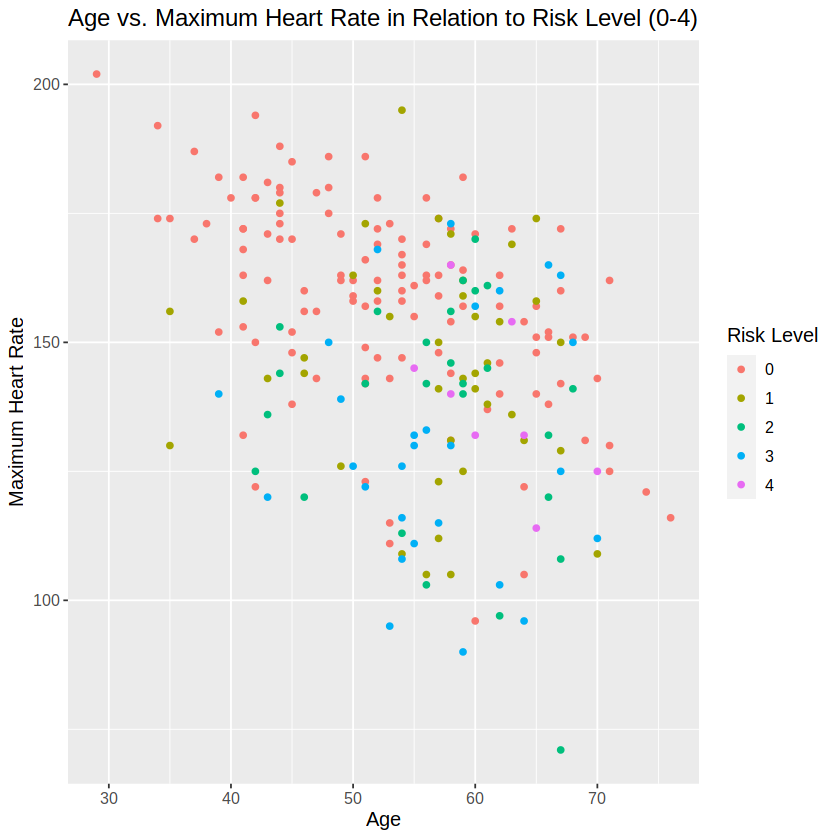

In [5]:
age_heartrate_plot_1 <- cleveland_train |>
                        mutate(risk_level = as_factor(risk_level)) |>
                        ggplot(aes(x = age, y = max_heartrate, color=risk_level)) +
                        geom_point() + 
                        xlab("Age") + 
                        ylab("Maximum Heart Rate") +
                        labs(color = "Risk Level") +
                        ggtitle("Age vs. Maximum Heart Rate in Relation to Risk Level (0-4)") +
                        theme(text = element_text(size=12))

age_heartrate_plot_1

Fig 1: Scatter plot showing age and maximum heart rate corresponding to risks level 0,1,2,3, and 4. 

The scatter plot shown in Figure 1 does not do a good job in visualising the correlation between the predictors (age and maximum heart rate) and the classes. Since we know there is a certain risk associated with heart disease for classes 1-4, we grouped these classes together to better visualise data. (Shown in the Figure 2 below)
In addition, there is past clinical analysis that grouped classes 1-4 together **(1 as “Risk of Heart Disease” and 0 as “No Risk of Heart Disease”)** to analyse the data, which suggests grouping the classes together shows to be most effective.


Risk Level,Mean Age,Mean Maximum Heartrate
<dbl>,<dbl>,<dbl>
0,52.63115,158.6803
1,56.75728,138.5243


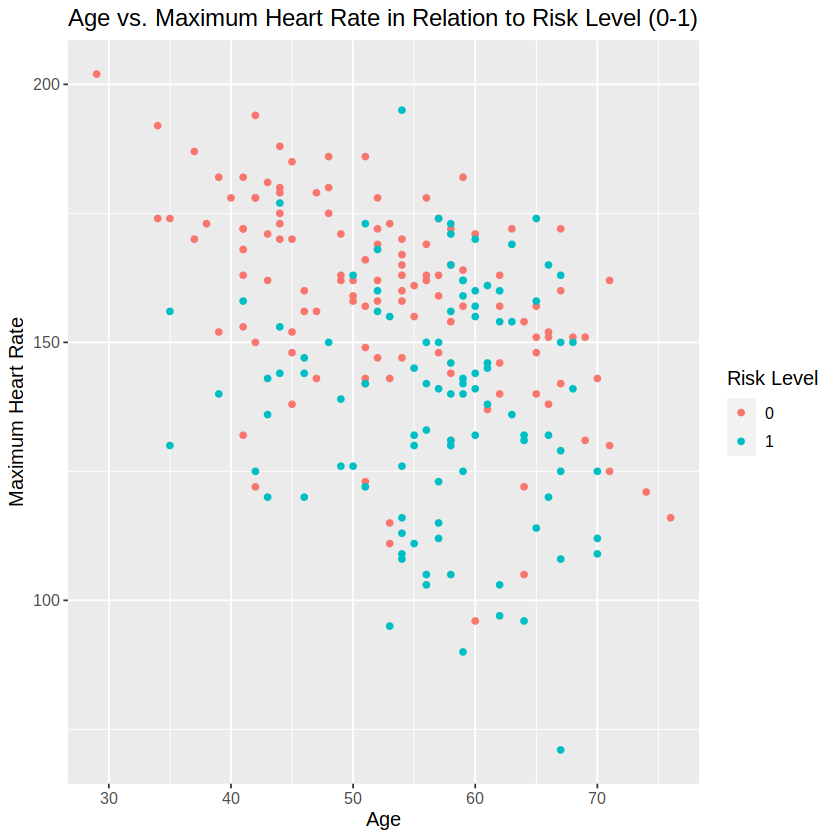

In [6]:
cleveland_train_mutated <- cleveland_train|>
                    mutate(risk_level=case_when(risk_level==0~0,risk_level==1~1,
                                         risk_level==2~1,risk_level==3~1,risk_level==4~1))

predictor_mean_values_2 <- cleveland_train_mutated |>
                        select(age, max_heartrate,risk_level) |>
                        group_by(risk_level) |>
                        summarize(across(age:max_heartrate, mean)) |>
                        rename("Mean Age" = age,
                               "Mean Maximum Heartrate" = max_heartrate,
                               "Risk Level" = risk_level)

predictor_mean_values_2

age_heartrate_plot_2 <- cleveland_train_mutated |>
                        mutate(risk_level = as_factor(risk_level)) |>
                        ggplot(aes(x = age, y = max_heartrate, color=risk_level)) +
                        geom_point() + 
                        xlab("Age") +  
                        ylab("Maximum Heart Rate") +
                        labs(color = "Risk Level") +
                        ggtitle("Age vs. Maximum Heart Rate in Relation to Risk Level (0-1)") +
                        theme(text = element_text(size=12))


age_heartrate_plot_2

Fig 2: Scatter plot showing age and maximum heart rate corresponding to risk levels 0 and 1.

*0 implies no risk of heart disease and 1 implies a risk of heart disease.*